In [19]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import json

In [20]:
with open(r"D:\dtc-dr\models\feature-selection\mlp\cv_scores_mlp.json") as f:
    cv_scores = json.load(f)

target_values = [
    "Stage1.Output.Measurement1.U.Actual",
    "Stage1.Output.Measurement7.U.Actual",
    "Stage1.Output.Measurement11.U.Actual",
    "FirstStage.CombinerOperation.Temperature1.U.Actual",
    "FirstStage.CombinerOperation.Temperature2.U.Actual",
]

In [21]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ["constant", "invscaling", "adaptive"]
}

In [22]:
df = pd.read_csv(
    r"D:\dtc-dr\data-analyse\continuous_factory_process.csv", delimiter=","
)

prefixes_to_match = ["Machine1", "Machine2", "Machine3"]

filtered_columns = [
    col
    for col in df.columns
    if any(col.startswith(prefix) for prefix in prefixes_to_match)
]
def calculate_best_regression_model():
    results_dict = {}

    for key, value in cv_scores.items():
        if key in target_values:
            indices = value["indices"]
            X = []
            for index, value in enumerate(indices):
                X.append(filtered_columns[value])
            X = df[X]   
            y = df[key]
            X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
    )
            mlp = MLPRegressor()
            grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

            # Fit the model to the training data
            grid_search.fit(X_train, y_train)

            # Get the best hyperparameters
            best_params = grid_search.best_params_

            # Make predictions on both the training and test sets
            y_train_pred = grid_search.predict(X_train)
            y_test_pred = grid_search.predict(X_test)

            # Calculate R2 score for training and test sets
            r2_train = r2_score(y_train, y_train_pred)
            r2_test = r2_score(y_test, y_test_pred)

            # Calculate RMSE for training and test sets
            rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
            rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

            # Calculate MSE for training and test sets
            mse_train = mean_squared_error(y_train, y_train_pred)
            mse_test = mean_squared_error(y_test, y_test_pred)

            # Create a new dictionary with updated hyperparameter values
            updated_hyperparameters = {
                'hidden_layer_sizes': best_params['hidden_layer_sizes'],
                'activation': best_params['activation'],
                'alpha': best_params['alpha'],
                'learning_rate': best_params['learning_rate'],
            }

            results_dict[key] = {
                "r2_train": r2_train,
                "r2_test": r2_test,
                "rmse_train": rmse_train,
                "rmse_test": rmse_test,
                "mse_train": mse_train,
                "mse_test": mse_test,
                "best_param": updated_hyperparameters,
            }
    return results_dict
     

results = calculate_best_regression_model()
# Save the results to a JSON file
with open('MLP_hyperparametertuning_results.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)


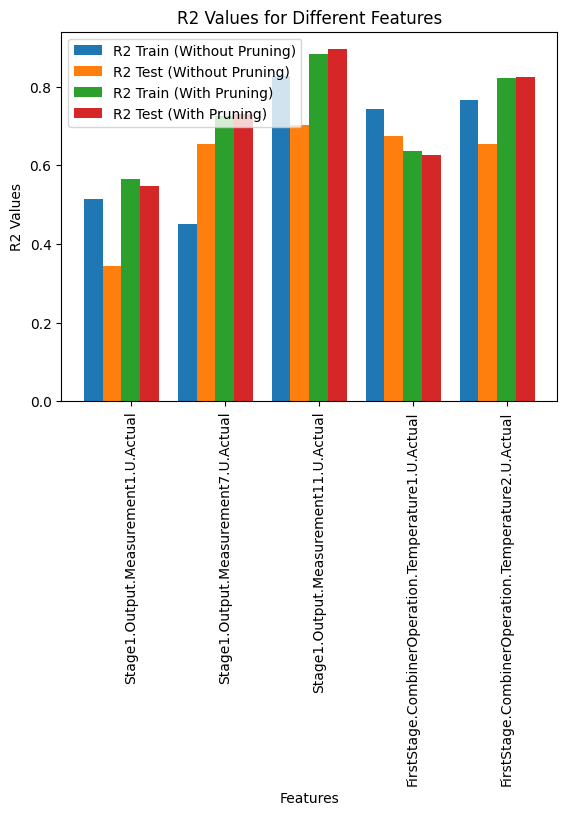

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json

target_values = [
    "Stage1.Output.Measurement1.U.Actual",
    "Stage1.Output.Measurement7.U.Actual",
    "Stage1.Output.Measurement11.U.Actual",
    "FirstStage.CombinerOperation.Temperature1.U.Actual",
    "FirstStage.CombinerOperation.Temperature2.U.Actual",
]

with open('MLP_hyperparametertuning_results.json') as json_file2:
    results = json.load(json_file2)

with open(r'D:\dtc-dr\models\feature-selection\mlp\cv_scores_mlp.json') as json_file:
    data = json.load(json_file)

r2_train_mlp_with_optimization = [value["r2_train"] for key, value in results.items()]
r2_test_mlp_with_optimization = [value["r2_test"] for key, value in results.items()]

r2_train_mlp_without_optimization = [value["r2_scores_train"] for key, value in data.items() if key in target_values]
r2_test_mlp_without_optimization = [value["r2_scores_test"] for key, value in data.items() if key in target_values]

# Set up positions for the bars
bar_width = 0.2
index = np.arange(len(target_values))

# Plot the bars
plt.bar(index - 1.5 * bar_width, r2_train_mlp_without_optimization, width=bar_width, label='R2 Train (Without Pruning)')
plt.bar(index - 0.5 * bar_width, r2_test_mlp_without_optimization, width=bar_width, label='R2 Test (Without Pruning)')
plt.bar(index + 0.5 * bar_width, r2_train_mlp_with_optimization, width=bar_width, label='R2 Train (With Pruning)')
plt.bar(index + 1.5 * bar_width, r2_test_mlp_with_optimization, width=bar_width, label='R2 Test (With Pruning)')

# Add labels, title, and legend
plt.xlabel('Features')
plt.ylabel('R2 Values')
plt.title('R2 Values for Different Features')
plt.xticks(index + bar_width / 2, target_values, rotation=90)  # Set rotation angle to 0 for horizontal labels
plt.legend()

# Show the plot
plt.show()

In [8]:
r2_train_mlp_with_optimization = [round(r2, 2) for r2 in r2_train_mlp_with_optimization]
r2_test_mlp_with_optimization = [round(r2, 2) for r2 in r2_test_mlp_with_optimization]
r2_train_mlp_without_optimization = [round(r2, 2) for r2 in r2_train_mlp_without_optimization]
r2_test_mlp_without_optimization = [round(r2, 2) for r2 in r2_test_mlp_without_optimization]

with open(r"D:\dtc-dr\models\feature-selection\mlp\hypertuning\mlp_ga_cv.json") as f2:
    mlp_ga_with_cv = json.load(f2)

features = [key for key, value in mlp_ga_with_cv.items()]
r2_train_with_ga = [round(value["mean_r2_scores_train"], 2) for key, value in mlp_ga_with_cv.items()]
r2_test_with_ga = [round(value["mean_r2_scores_test"], 2) for key, value in mlp_ga_with_cv.items()]


import pandas as pd

df = pd.DataFrame({
    'Feature': target_values,
    'r2_train_with_ga': r2_train_with_ga,
    'r2_test_with_ga': r2_test_with_ga,
    'r2_train_mlp_with_optimization': r2_train_mlp_with_optimization,
    'r2_test_mlp_with_optimization': r2_test_mlp_with_optimization,
    'r2_train_mlp_without_optimization': r2_train_mlp_without_optimization,
    'r2_test_mlp_without_optimization': r2_test_mlp_without_optimization
})
df
# Displaying the DataFrame
# print(df.to_excel("evaluation_mlp.xlsx", index=False))


,Feature,r2_train_with_ga,r2_test_with_ga,r2_train_mlp_with_optimization,r2_test_mlp_with_optimization,r2_train_mlp_without_optimization,r2_test_mlp_without_optimization
0,Stage1.Output.Measurement1.U.Actual,0.60,0.59,0.56,0.55,0.51,0.34
1,Stage1.Output.Measurement7.U.Actual,0.79,0.80,0.73,0.73,0.45,0.66
2,Stage1.Output.Measurement11.U.Actual,0.90,0.89,0.88,0.89,0.83,0.70
3,FirstStage.CombinerOperation.Temperature1.U.Ac...,0.84,0.80,0.64,0.63,0.74,0.67
4,FirstStage.CombinerOperation.Temperature2.U.Ac...,0.87,0.86,0.82,0.82,0.77,0.65
